# AIR QUALITY FORECASTING (PM2.5 & AQI) 
## Using LSTM - PyTorch on GPU

---

### Table of Contents
1. **Import Libraries & Configuration**
2. **Load and Preprocess Data**
3. **Create Sequences for Time Series**
4. **Build LSTM Model**
5. **Train Model on GPU**
6. **Evaluate Model**
7. **Future Forecasting**
8. **Conclusion**

---

### Objectives
- Forecast PM2.5 concentration and AQI for the future
- Use LSTM (Long Short-Term Memory) model
- Train on GPU with PyTorch
- Evaluate model performance with metrics: MAE, RMSE, R²


In [1]:
# =============================================================================
# 1. IMPORT LIBRARIES & CONFIGURATION
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import warnings
import os
from datetime import datetime, timedelta

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("GPU not available, using CPU")

# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("\nSuccessfully imported all libraries!")


Device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Successfully imported all libraries!


## 2. LOAD AND PREPROCESS DATA


In [2]:
# =============================================================================
# 2. LOAD AND PREPROCESS DATA
# =============================================================================

# Load all data
data_path = '/kaggle/input/data-air-cn/'
all_files = glob(data_path + '*.csv')

print(f"Found {len(all_files)} data files")

# Merge all files
df_list = []
for file in all_files:
    df_temp = pd.read_csv(file)
    df_list.append(df_temp)
    
df = pd.concat(df_list, ignore_index=True)
print(f"Total rows: {len(df):,}")

# Create datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# View data
df.head()


Found 12 data files
Total rows: 420,768


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan,2013-03-01 00:00:00
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan,2013-03-01 01:00:00
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan,2013-03-01 02:00:00
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan,2013-03-01 04:00:00


In [3]:
# Select one station for training (or use average of all stations)
# Using average of all stations over time
df_avg = df.groupby('datetime').agg({
    'PM2.5': 'mean',
    'PM10': 'mean',
    'SO2': 'mean',
    'NO2': 'mean',
    'CO': 'mean',
    'O3': 'mean',
    'TEMP': 'mean',
    'PRES': 'mean',
    'DEWP': 'mean',
    'RAIN': 'mean',
    'WSPM': 'mean'
}).reset_index()

df_avg = df_avg.sort_values('datetime').reset_index(drop=True)

print(f"Average data over time: {len(df_avg):,} rows")
print(f"From: {df_avg['datetime'].min()}")
print(f"To: {df_avg['datetime'].max()}")

df_avg.head()


Average data over time: 35,064 rows
From: 2013-03-01 00:00:00
To: 2017-02-28 23:00:00


,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013-03-01 00:00:00,5.666667,7.916667,5.666667,12.600000,308.333333,75.416667,-0.916667,1022.766667,-19.900000,0.0,4.175000
1,2013-03-01 01:00:00,6.833333,9.833333,5.333333,13.111111,308.333333,75.750000,-1.216667,1023.191667,-19.916667,0.0,3.875000
2,2013-03-01 02:00:00,5.666667,7.250000,8.166667,12.900000,300.000000,66.000000,-1.591667,1023.325000,-21.008333,0.0,4.400000
3,2013-03-01 03:00:00,6.000000,9.250000,5.833333,12.400000,283.333333,75.333333,-1.891667,1024.208333,-21.833333,0.0,3.366667
4,2013-03-01 04:00:00,4.833333,6.916667,6.750000,14.000000,308.333333,66.333333,-2.283333,1024.866667,-21.625000,0.0,2.716667


In [4]:
# Handle missing values
print("Check missing values:")
print(df_avg.isnull().sum())

# Interpolate missing values
df_avg = df_avg.interpolate(method='linear')
df_avg = df_avg.fillna(method='bfill').fillna(method='ffill')

print("\nMissing values handled!")
print(f"Remaining missing: {df_avg.isnull().sum().sum()}")


Check missing values:
datetime      0
PM2.5        81
PM10         83
SO2          87
NO2          87
CO          204
O3          107
TEMP         18
PRES         18
DEWP         18
RAIN         18
WSPM         12
dtype: int64

Missing values handled!
Remaining missing: 0


In [5]:
# Add time features
df_avg['hour'] = df_avg['datetime'].dt.hour
df_avg['day'] = df_avg['datetime'].dt.day
df_avg['month'] = df_avg['datetime'].dt.month
df_avg['dayofweek'] = df_avg['datetime'].dt.dayofweek
df_avg['dayofyear'] = df_avg['datetime'].dt.dayofyear

print("Added time features!")
df_avg.head()


Added time features!


,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,hour,day,month,dayofweek,dayofyear
0,2013-03-01 00:00:00,5.666667,7.916667,5.666667,12.600000,308.333333,75.416667,-0.916667,1022.766667,-19.900000,0.0,4.175000,0,1,3,4,60
1,2013-03-01 01:00:00,6.833333,9.833333,5.333333,13.111111,308.333333,75.750000,-1.216667,1023.191667,-19.916667,0.0,3.875000,1,1,3,4,60
2,2013-03-01 02:00:00,5.666667,7.250000,8.166667,12.900000,300.000000,66.000000,-1.591667,1023.325000,-21.008333,0.0,4.400000,2,1,3,4,60
3,2013-03-01 03:00:00,6.000000,9.250000,5.833333,12.400000,283.333333,75.333333,-1.891667,1024.208333,-21.833333,0.0,3.366667,3,1,3,4,60
4,2013-03-01 04:00:00,4.833333,6.916667,6.750000,14.000000,308.333333,66.333333,-2.283333,1024.866667,-21.625000,0.0,2.716667,4,1,3,4,60


## 2.1 CALCULATE COMPOSITE AQI FROM 6 POLLUTANTS

According to EPA (Environmental Protection Agency) standards, AQI is calculated from 6 main pollutants:
- **PM2.5** (Particulate Matter 2.5 μm)
- **PM10** (Particulate Matter 10 μm)
- **O3** (Ozone)
- **NO2** (Nitrogen Dioxide)
- **SO2** (Sulfur Dioxide)
- **CO** (Carbon Monoxide)

**Composite AQI = MAX(AQI of each pollutant)**


In [6]:
# =============================================================================
# CALCULATE COMPOSITE AQI FROM 6 POLLUTANTS (EPA STANDARD)
# =============================================================================

def calculate_aqi_linear(concentration, breakpoints):
    """
    Calculate AQI using EPA linear formula
    breakpoints: list of (C_lo, C_hi, I_lo, I_hi)
    """
    if pd.isna(concentration) or concentration < 0:
        return np.nan
    
    for c_lo, c_hi, i_lo, i_hi in breakpoints:
        if c_lo <= concentration <= c_hi:
            aqi = ((i_hi - i_lo) / (c_hi - c_lo)) * (concentration - c_lo) + i_lo
            return round(aqi)
    
    # If exceeds highest threshold
    if concentration > breakpoints[-1][1]:
        return 500
    return np.nan

# EPA standard breakpoints for each pollutant
# Format: (C_lo, C_hi, I_lo, I_hi)

# PM2.5 (μg/m³) - 24-hour average
PM25_BREAKPOINTS = [
    (0.0, 12.0, 0, 50),
    (12.1, 35.4, 51, 100),
    (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200),
    (150.5, 250.4, 201, 300),
    (250.5, 500.4, 301, 500),
]

# PM10 (μg/m³) - 24-hour average
PM10_BREAKPOINTS = [
    (0, 54, 0, 50),
    (55, 154, 51, 100),
    (155, 254, 101, 150),
    (255, 354, 151, 200),
    (355, 424, 201, 300),
    (425, 604, 301, 500),
]

# O3 (μg/m³) - converted from ppb, 8-hour average
# 1 ppb O3 ≈ 2 μg/m³
O3_BREAKPOINTS = [
    (0, 108, 0, 50),       # 0-54 ppb
    (109, 140, 51, 100),   # 55-70 ppb
    (141, 170, 101, 150),  # 71-85 ppb
    (171, 210, 151, 200),  # 86-105 ppb
    (211, 400, 201, 300),  # 106-200 ppb
    (401, 800, 301, 500),
]

# NO2 (μg/m³) - 1-hour average
# 1 ppb NO2 ≈ 1.88 μg/m³
NO2_BREAKPOINTS = [
    (0, 100, 0, 50),
    (101, 188, 51, 100),
    (189, 677, 101, 150),
    (678, 1221, 151, 200),
    (1222, 2350, 201, 300),
    (2351, 3850, 301, 500),
]

# SO2 (μg/m³) - 1-hour average
# 1 ppb SO2 ≈ 2.62 μg/m³
SO2_BREAKPOINTS = [
    (0, 92, 0, 50),
    (93, 197, 51, 100),
    (198, 487, 101, 150),
    (488, 797, 151, 200),
    (798, 1583, 201, 300),
    (1584, 2630, 301, 500),
]

# CO (mg/m³) - converted from ppm, 8-hour average
# 1 ppm CO ≈ 1.145 mg/m³
CO_BREAKPOINTS = [
    (0, 5.0, 0, 50),
    (5.1, 10.5, 51, 100),
    (10.6, 14.3, 101, 150),
    (14.4, 17.6, 151, 200),
    (17.7, 34.8, 201, 300),
    (34.9, 57.5, 301, 500),
]

# Calculate AQI for each pollutant
df_avg['AQI_PM25'] = df_avg['PM2.5'].apply(lambda x: calculate_aqi_linear(x, PM25_BREAKPOINTS))
df_avg['AQI_PM10'] = df_avg['PM10'].apply(lambda x: calculate_aqi_linear(x, PM10_BREAKPOINTS))
df_avg['AQI_O3'] = df_avg['O3'].apply(lambda x: calculate_aqi_linear(x, O3_BREAKPOINTS))
df_avg['AQI_NO2'] = df_avg['NO2'].apply(lambda x: calculate_aqi_linear(x, NO2_BREAKPOINTS))
df_avg['AQI_SO2'] = df_avg['SO2'].apply(lambda x: calculate_aqi_linear(x, SO2_BREAKPOINTS))
df_avg['AQI_CO'] = df_avg['CO'].apply(lambda x: calculate_aqi_linear(x/1000, CO_BREAKPOINTS))  # CO in data is μg/m³

# Calculate composite AQI = MAX of all component AQIs
aqi_columns = ['AQI_PM25', 'AQI_PM10', 'AQI_O3', 'AQI_NO2', 'AQI_SO2', 'AQI_CO']
df_avg['AQI'] = df_avg[aqi_columns].max(axis=1)

# Determine dominant pollutant
def get_dominant_pollutant(row):
    pollutants = ['PM25', 'PM10', 'O3', 'NO2', 'SO2', 'CO']
    aqi_values = [row[f'AQI_{p}'] for p in pollutants]
    max_idx = np.nanargmax(aqi_values)
    return pollutants[max_idx]

df_avg['Dominant_Pollutant'] = df_avg.apply(get_dominant_pollutant, axis=1)

print("COMPOSITE AQI CALCULATED FROM 6 POLLUTANTS!")
print("="*60)
print(f"\nAQI Statistics by Pollutant:")
print(df_avg[aqi_columns + ['AQI']].describe().round(2))


COMPOSITE AQI CALCULATED FROM 6 POLLUTANTS!

AQI Statistics by Pollutant:
       AQI_PM25  AQI_PM10    AQI_O3   AQI_NO2   AQI_SO2    AQI_CO       AQI
count  34988.00  34772.00  34886.00  34946.00  35047.00  35036.00  35064.00
mean     140.55     73.26     33.71     25.34      8.57     12.28    144.07
std       78.08     51.70     45.61     14.95     10.64     10.45     78.84
min       14.00      4.00      0.00      2.00      1.00      1.00     15.00
25%       74.00     38.00      7.00     14.00      2.00      5.00     76.00
50%      152.00     66.00     20.00     23.00      4.00      9.00    154.00
75%      179.00     94.00     36.00     34.00     11.00     15.00    183.00
max      500.00    500.00    272.00    101.00    110.00     85.00    500.00


In [7]:
# Classify AQI by level
def classify_aqi(aqi):
    if pd.isna(aqi):
        return 'Unknown'
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df_avg['AQI_Category'] = df_avg['AQI'].apply(classify_aqi)

# Statistics for AQI level distribution and dominant pollutant
print("\nAQI LEVEL DISTRIBUTION:")
print("-"*40)
aqi_dist = df_avg['AQI_Category'].value_counts()
for cat in ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']:
    if cat in aqi_dist.index:
        count = aqi_dist[cat]
        pct = count / len(df_avg) * 100
        print(f"  • {cat:25s}: {count:6,} ({pct:5.1f}%)")

print("\nDOMINANT POLLUTANT:")
print("-"*40)
dom_dist = df_avg['Dominant_Pollutant'].value_counts()
for pol, count in dom_dist.items():
    pct = count / len(df_avg) * 100
    print(f"  • {pol:6s}: {count:6,} ({pct:5.1f}%)")



AQI LEVEL DISTRIBUTION:
----------------------------------------
  • Good                     :  4,116 ( 11.7%)
  • Moderate                 :  7,706 ( 22.0%)
  • Unhealthy for Sensitive  :  4,690 ( 13.4%)
  • Unhealthy                : 12,544 ( 35.8%)
  • Very Unhealthy           :  4,503 ( 12.8%)
  • Hazardous                :  1,505 (  4.3%)

DOMINANT POLLUTANT:
----------------------------------------
  • PM25  : 31,065 ( 88.6%)
  • O3    :  3,037 (  8.7%)
  • PM10  :    957 (  2.7%)
  • NO2   :      5 (  0.0%)


## 2.2 CORRELATION ANALYSIS BETWEEN POLLUTANTS AND AQI

Analyzing relationships between:
- Pollutant concentrations (PM2.5, PM10, O3, NO2, SO2, CO)
- Weather factors (TEMP, PRES, DEWP, RAIN, WSPM)
- Composite AQI


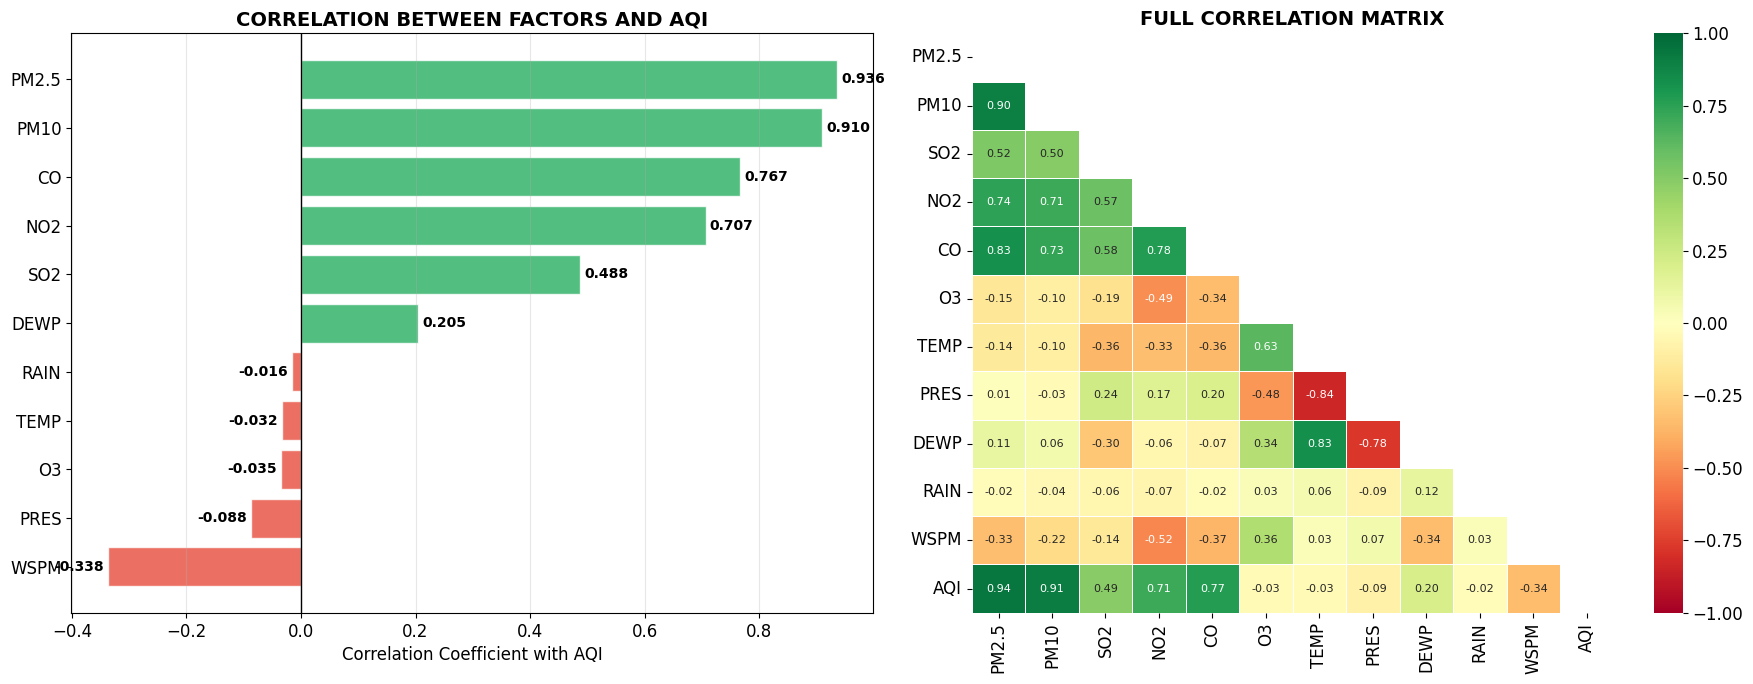


TOP 5 FACTORS WITH HIGHEST AQI CORRELATION:
--------------------------------------------------
  1. PM2.5   : +0.9362
  2. PM10    : +0.9096
  3. CO      : +0.7673
  4. NO2     : +0.7066
  5. SO2     : +0.4881


In [8]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================

# Columns for correlation analysis
pollutant_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
weather_cols = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
aqi_component_cols = ['AQI_PM25', 'AQI_PM10', 'AQI_O3', 'AQI_NO2', 'AQI_SO2', 'AQI_CO']
target_cols = ['PM2.5', 'AQI']

# 1. Correlation Matrix between pollutants and AQI
correlation_cols = pollutant_cols + weather_cols + ['AQI']
corr_matrix = df_avg[correlation_cols].corr()

# Visualize correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap 1: Correlation with AQI
aqi_corr = corr_matrix['AQI'].drop('AQI').sort_values(ascending=True)
colors = ['#E74C3C' if x < 0 else '#27AE60' for x in aqi_corr.values]
bars = axes[0].barh(aqi_corr.index, aqi_corr.values, color=colors, edgecolor='white', alpha=0.8)
axes[0].axvline(x=0, color='black', linewidth=1)
axes[0].set_xlabel('Correlation Coefficient with AQI')
axes[0].set_title('CORRELATION BETWEEN FACTORS AND AQI', fontweight='bold', fontsize=14)
axes[0].grid(axis='x', alpha=0.3)

# Add values on bars
for bar, val in zip(bars, aqi_corr.values):
    width = bar.get_width()
    axes[0].annotate(f'{val:.3f}',
                    xy=(width, bar.get_y() + bar.get_height()/2),
                    xytext=(3 if width >= 0 else -3, 0),
                    textcoords="offset points",
                    ha='left' if width >= 0 else 'right', va='center',
                    fontsize=10, fontweight='bold')

# Heatmap 2: Full correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, linewidths=0.5, ax=axes[1], vmin=-1, vmax=1,
            annot_kws={'size': 8})
axes[1].set_title('FULL CORRELATION MATRIX', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

# Print top correlations
print("\nTOP 5 FACTORS WITH HIGHEST AQI CORRELATION:")
print("-"*50)
aqi_corr_abs = aqi_corr.abs().sort_values(ascending=False)
for i, (feat, corr) in enumerate(aqi_corr_abs.head(5).items()):
    orig_corr = aqi_corr[feat]
    sign = "+" if orig_corr > 0 else ""
    print(f"  {i+1}. {feat:8s}: {sign}{orig_corr:.4f}")


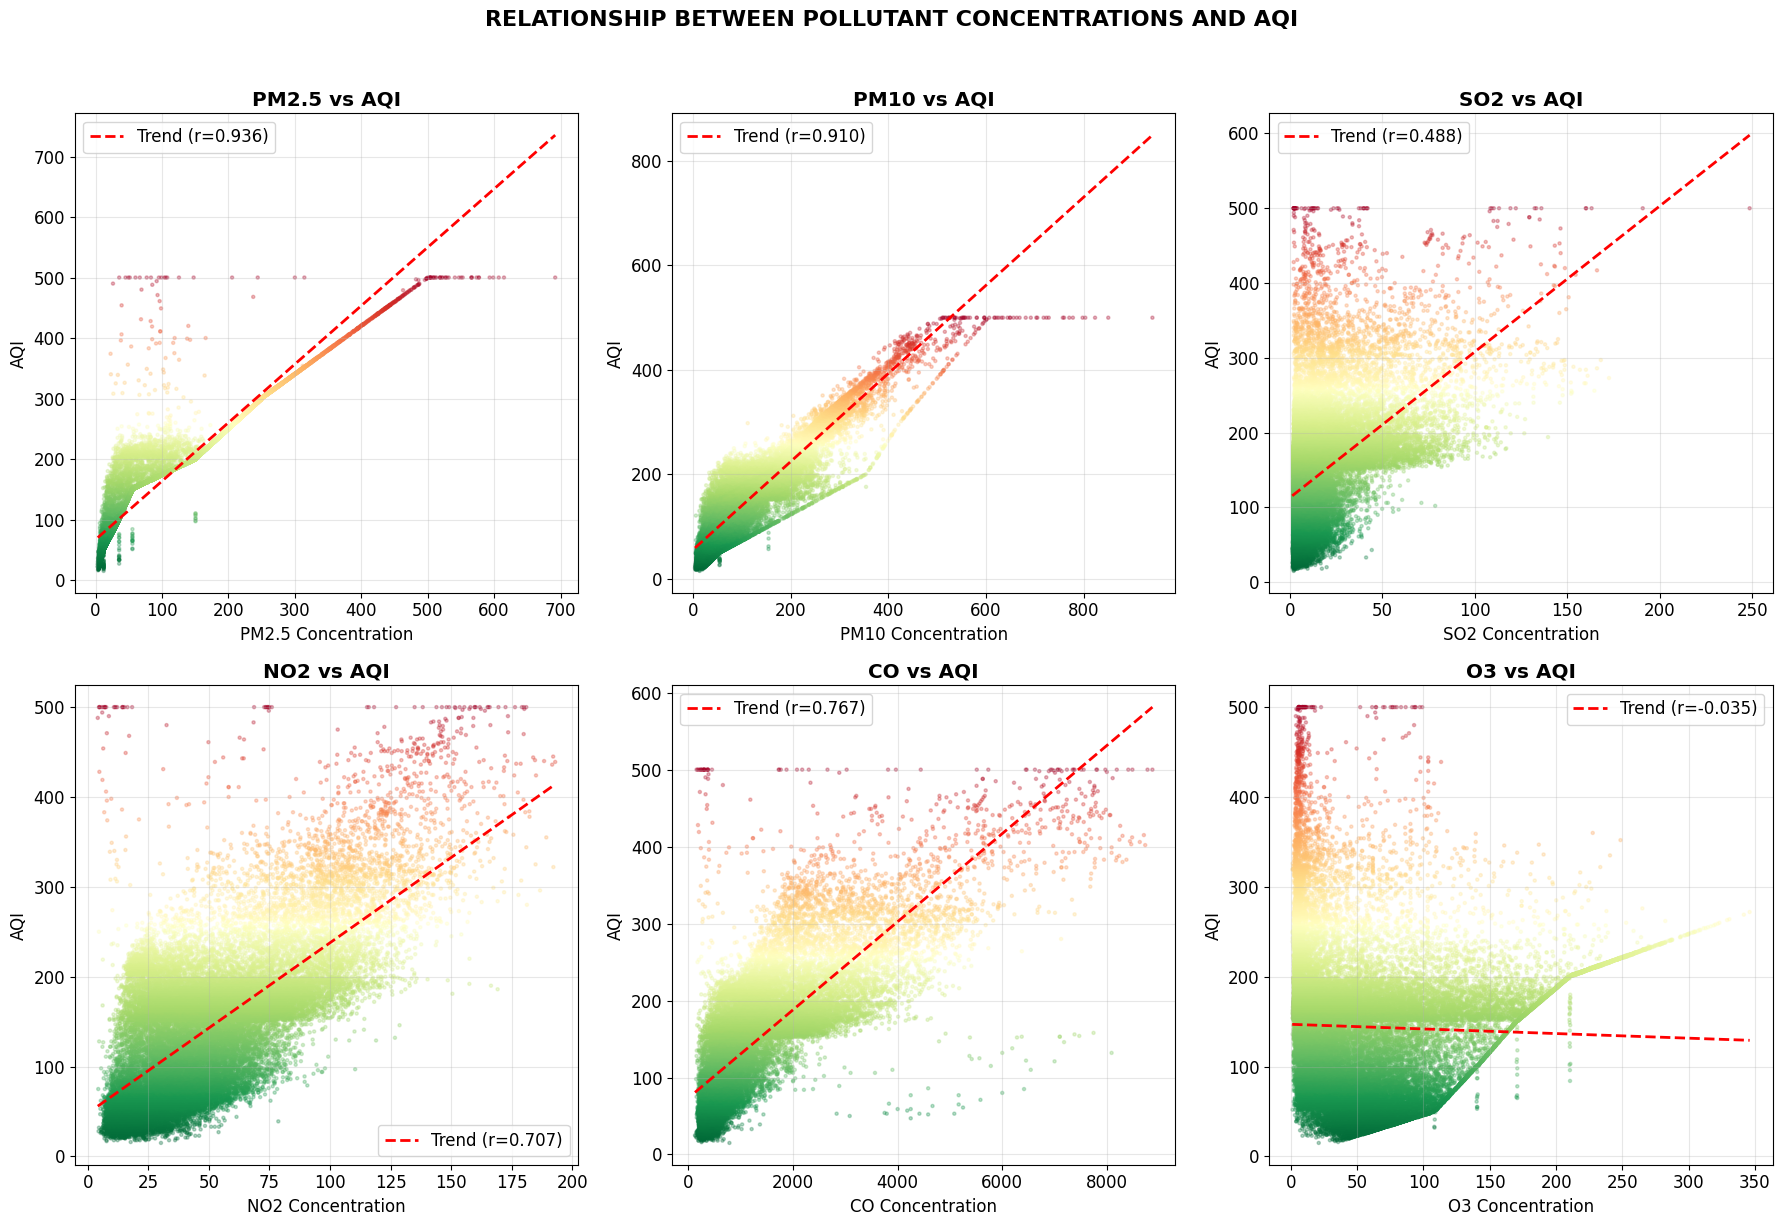

In [9]:
# =============================================================================
# DETAILED ANALYSIS: Contribution of each pollutant to AQI
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatter plots: Pollutant concentrations vs AQI
for idx, pollutant in enumerate(pollutant_cols):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    # Scatter colored by AQI category
    scatter = ax.scatter(df_avg[pollutant], df_avg['AQI'], 
                        c=df_avg['AQI'], cmap='RdYlGn_r', 
                        alpha=0.3, s=5)
    
    # Calculate correlation
    corr = df_avg[pollutant].corr(df_avg['AQI'])
    
    # Trend line
    z = np.polyfit(df_avg[pollutant].dropna(), df_avg.loc[df_avg[pollutant].notna(), 'AQI'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_avg[pollutant].min(), df_avg[pollutant].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Trend (r={corr:.3f})')
    
    ax.set_xlabel(f'{pollutant} Concentration')
    ax.set_ylabel('AQI')
    ax.set_title(f'{pollutant} vs AQI', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('RELATIONSHIP BETWEEN POLLUTANT CONCENTRATIONS AND AQI', 
             fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


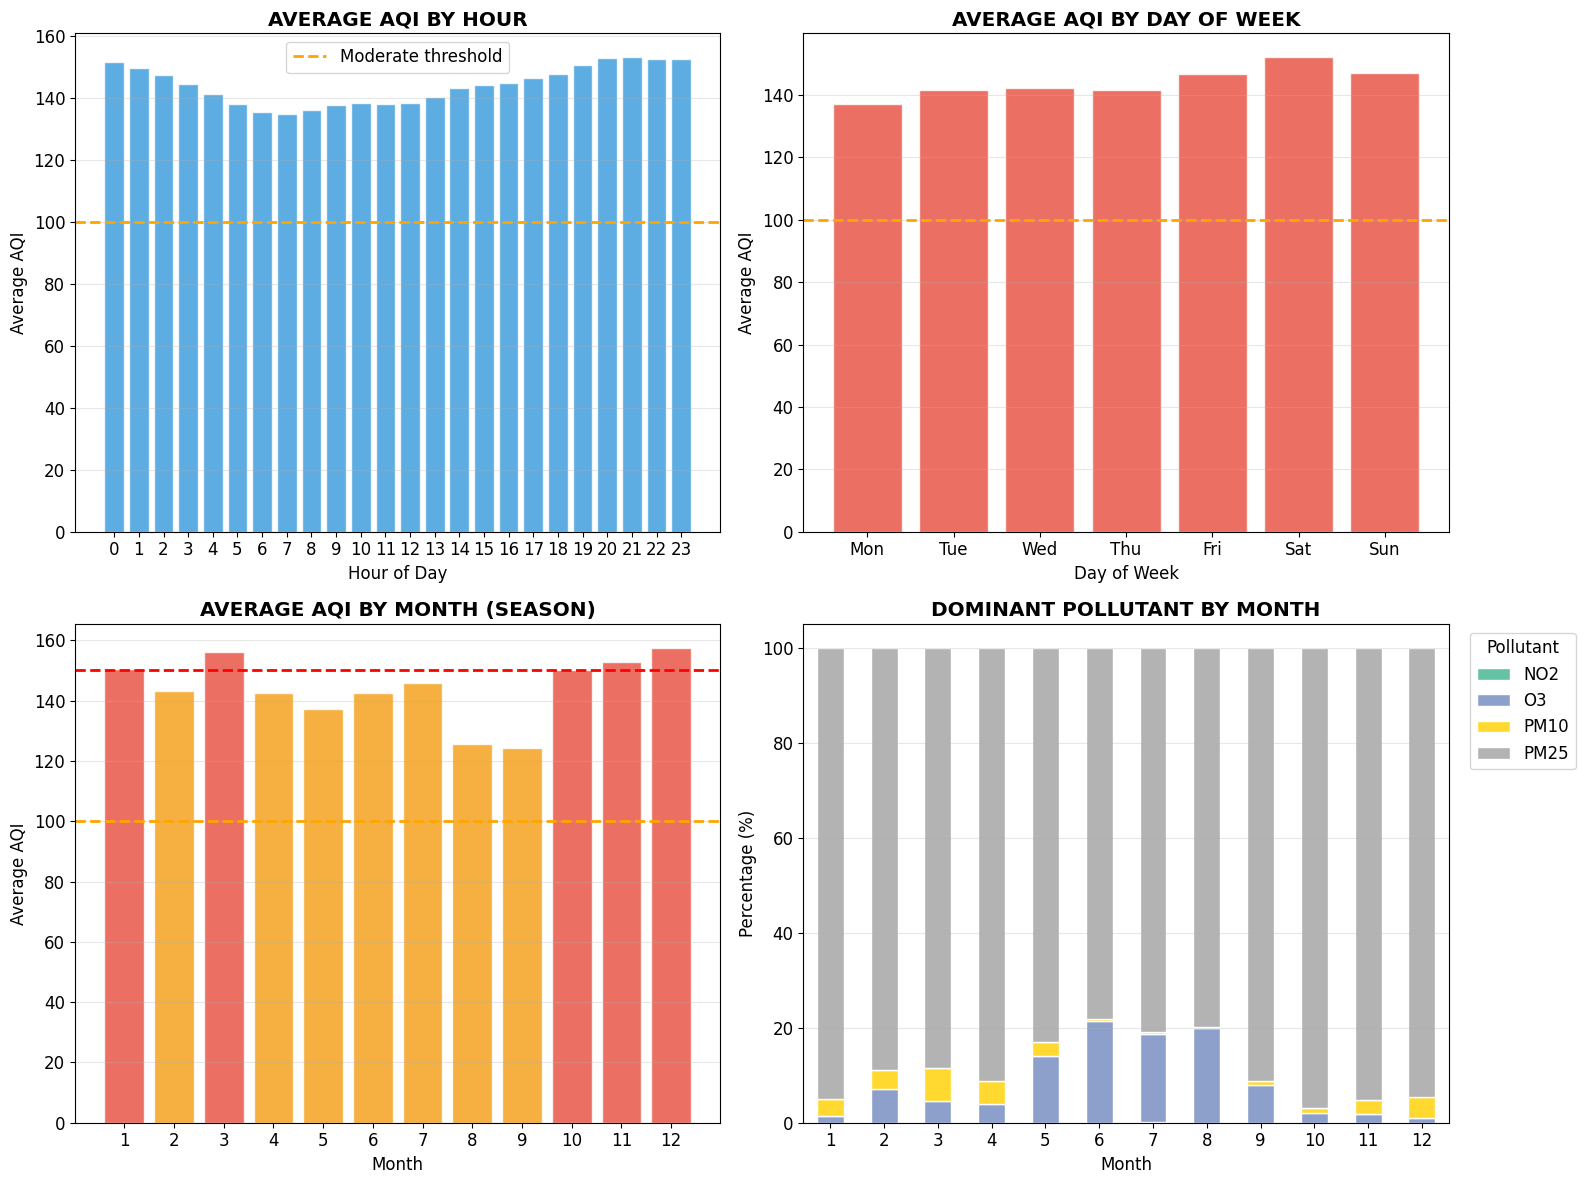


OBSERVATIONS:
------------------------------------------------------------
• Most polluted hour: 21h (AQI = 153.1)
• Most polluted month: Month 12 (AQI = 157.4)
• Least polluted month: Month 9 (AQI = 124.3)


In [10]:
# =============================================================================
# TEMPORAL ANALYSIS: AQI by hour, day, month
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AQI by hour of day
hourly_aqi = df_avg.groupby('hour')['AQI'].mean()
axes[0, 0].bar(hourly_aqi.index, hourly_aqi.values, color='#3498DB', edgecolor='white', alpha=0.8)
axes[0, 0].axhline(y=100, color='orange', linestyle='--', linewidth=2, label='Moderate threshold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average AQI')
axes[0, 0].set_title('AVERAGE AQI BY HOUR', fontweight='bold')
axes[0, 0].set_xticks(range(0, 24))
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. AQI by day of week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_aqi = df_avg.groupby('dayofweek')['AQI'].mean()
axes[0, 1].bar(days, daily_aqi.values, color='#E74C3C', edgecolor='white', alpha=0.8)
axes[0, 1].axhline(y=100, color='orange', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average AQI')
axes[0, 1].set_title('AVERAGE AQI BY DAY OF WEEK', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. AQI by month
monthly_aqi = df_avg.groupby('month')['AQI'].mean()
colors_month = ['#27AE60' if v < 100 else '#F39C12' if v < 150 else '#E74C3C' for v in monthly_aqi.values]
axes[1, 0].bar(monthly_aqi.index, monthly_aqi.values, color=colors_month, edgecolor='white', alpha=0.8)
axes[1, 0].axhline(y=100, color='orange', linestyle='--', linewidth=2)
axes[1, 0].axhline(y=150, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average AQI')
axes[1, 0].set_title('AVERAGE AQI BY MONTH (SEASON)', fontweight='bold')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Dominant pollutant by month
dom_by_month = df_avg.groupby(['month', 'Dominant_Pollutant']).size().unstack(fill_value=0)
dom_by_month_pct = dom_by_month.div(dom_by_month.sum(axis=1), axis=0) * 100
dom_by_month_pct.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                       colormap='Set2', edgecolor='white')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('DOMINANT POLLUTANT BY MONTH', fontweight='bold')
axes[1, 1].legend(title='Pollutant', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVATIONS:")
print("-"*60)
print(f"• Most polluted hour: {hourly_aqi.idxmax()}h (AQI = {hourly_aqi.max():.1f})")
print(f"• Most polluted month: Month {monthly_aqi.idxmax()} (AQI = {monthly_aqi.max():.1f})")
print(f"• Least polluted month: Month {monthly_aqi.idxmin()} (AQI = {monthly_aqi.min():.1f})")


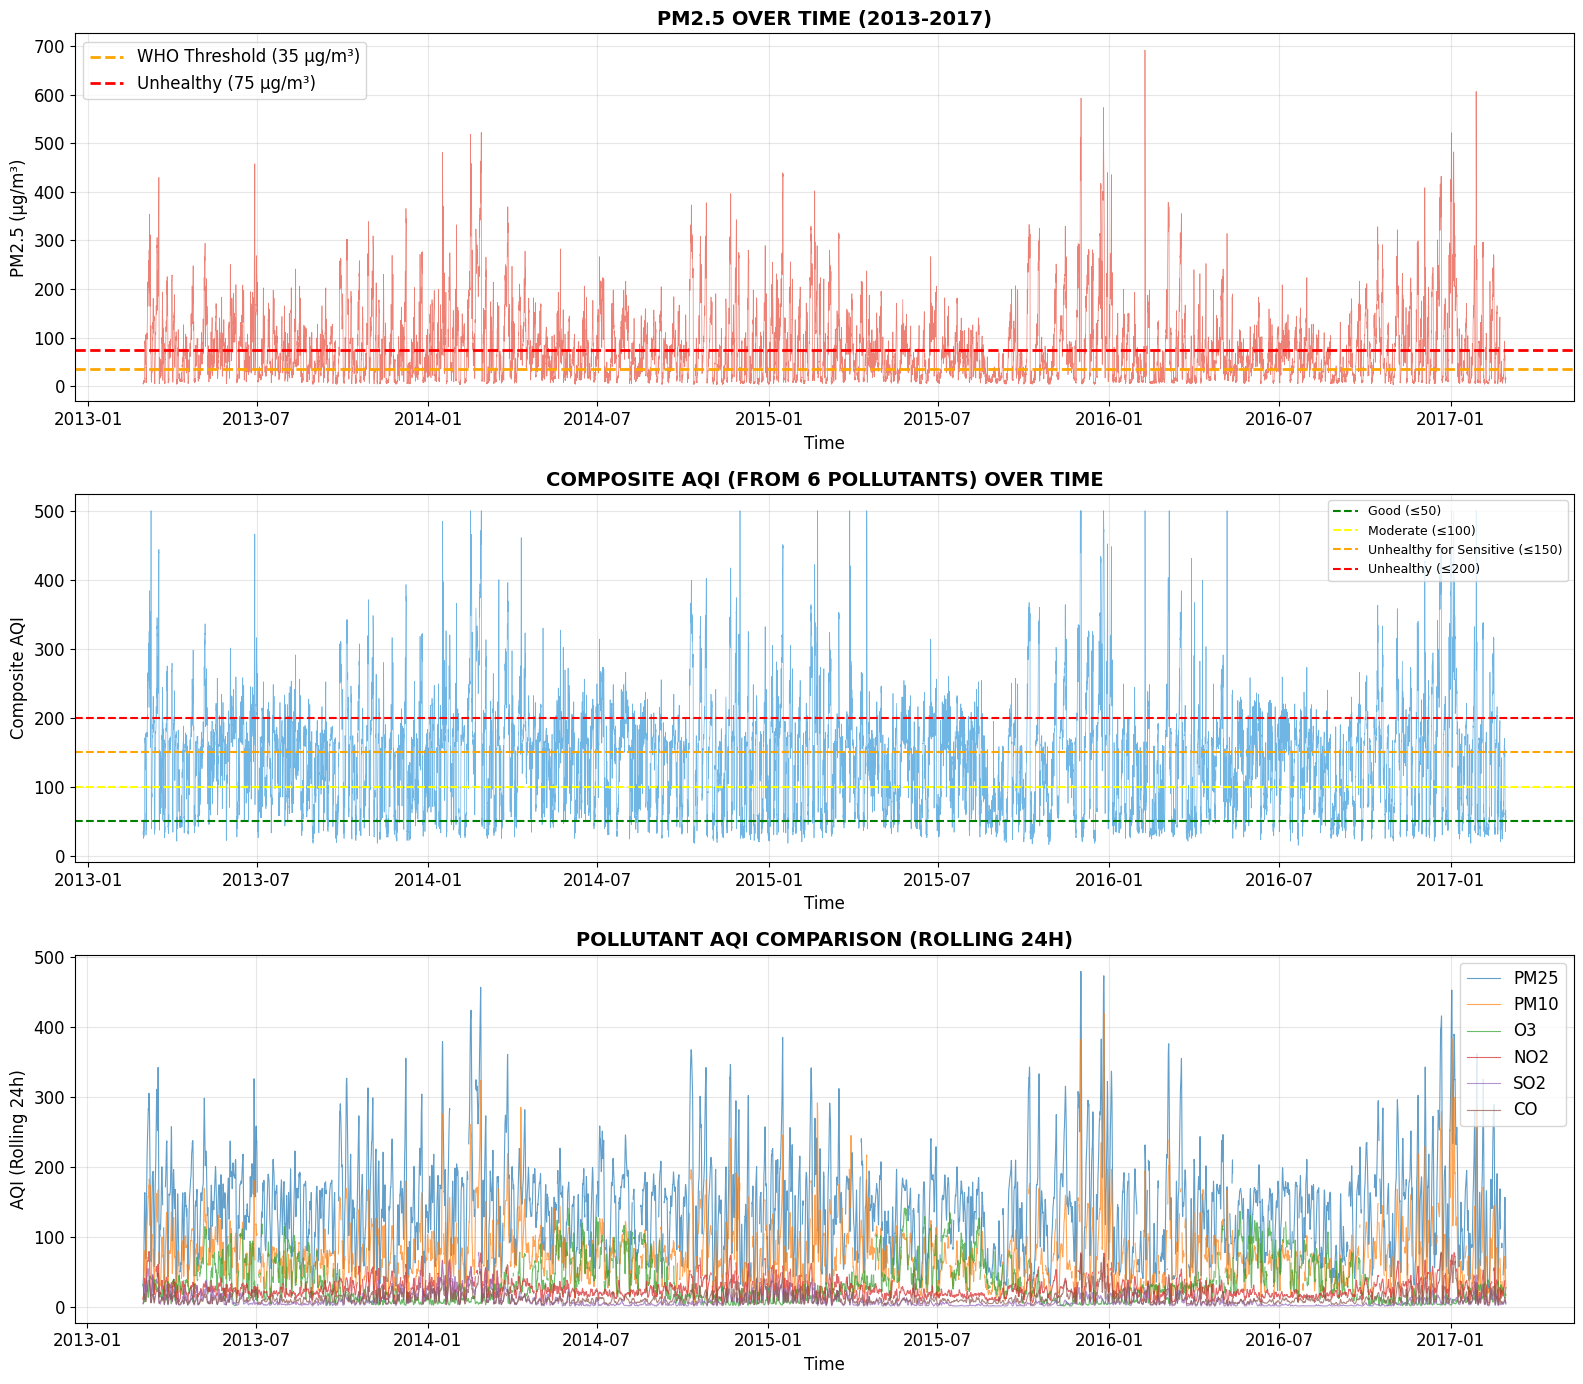

In [11]:
# =============================================================================
# VISUALIZE: PM2.5 AND COMPOSITE AQI OVER TIME
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# PM2.5 time series
axes[0].plot(df_avg['datetime'], df_avg['PM2.5'], alpha=0.7, linewidth=0.5, color='#E74C3C')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5 (μg/m³)')
axes[0].set_title('PM2.5 OVER TIME (2013-2017)', fontweight='bold', fontsize=14)
axes[0].axhline(y=35, color='orange', linestyle='--', linewidth=2, label='WHO Threshold (35 μg/m³)')
axes[0].axhline(y=75, color='red', linestyle='--', linewidth=2, label='Unhealthy (75 μg/m³)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Composite AQI time series
axes[1].plot(df_avg['datetime'], df_avg['AQI'], alpha=0.7, linewidth=0.5, color='#3498DB')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Composite AQI')
axes[1].set_title('COMPOSITE AQI (FROM 6 POLLUTANTS) OVER TIME', fontweight='bold', fontsize=14)
axes[1].axhline(y=50, color='green', linestyle='--', linewidth=1.5, label='Good (≤50)')
axes[1].axhline(y=100, color='yellow', linestyle='--', linewidth=1.5, label='Moderate (≤100)')
axes[1].axhline(y=150, color='orange', linestyle='--', linewidth=1.5, label='Unhealthy for Sensitive (≤150)')
axes[1].axhline(y=200, color='red', linestyle='--', linewidth=1.5, label='Unhealthy (≤200)')
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(alpha=0.3)

# Compare AQI from different pollutants (rolling average 24h)
aqi_rolling = df_avg[aqi_columns].rolling(24).mean()
for col in aqi_columns:
    label = col.replace('AQI_', '')
    axes[2].plot(df_avg['datetime'], aqi_rolling[col], alpha=0.7, linewidth=0.8, label=label)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('AQI (Rolling 24h)')
axes[2].set_title('POLLUTANT AQI COMPARISON (ROLLING 24H)', fontweight='bold', fontsize=14)
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🔧 3. DATA PREPARATION FOR LSTM

### 3.1 Parameter Configuration


In [12]:
# =============================================================================
# 3. DATA PREPARATION FOR LSTM - MULTI-OUTPUT (PM2.5 & AQI)
# =============================================================================

# Configuration
class Config:
    # Data parameters
    SEQUENCE_LENGTH = 24        # Use 24 hours before for forecasting
    FORECAST_HORIZON = 24       # Forecast next 24 hours
    
    # Features used (including component AQIs)
    FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 
                'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM',
                'hour', 'dayofweek', 'month', 'AQI']
    
    # Multi-output targets: Predict both PM2.5 and AQI
    TARGETS = ['PM2.5', 'AQI']
    NUM_OUTPUTS = 2
    
    # Model parameters
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.2
    
    # Training parameters
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 0.001
    PATIENCE = 10  # Early stopping
    
    # Train/Val/Test split
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

config = Config()

print("MULTI-OUTPUT MODEL CONFIGURATION (PM2.5 & AQI):")
print("="*60)
print(f"  • Sequence Length: {config.SEQUENCE_LENGTH} hours (input)")
print(f"  • Forecast Horizon: {config.FORECAST_HORIZON} hours (forecast)")
print(f"  • Features: {len(config.FEATURES)}")
print(f"  • Targets: {config.TARGETS} ({config.NUM_OUTPUTS} outputs)")
print(f"  • Hidden Size: {config.HIDDEN_SIZE}")
print(f"  • Num Layers: {config.NUM_LAYERS}")
print(f"  • Dropout: {config.DROPOUT}")
print(f"  • Batch Size: {config.BATCH_SIZE}")
print(f"  • Epochs: {config.EPOCHS}")
print(f"  • Learning Rate: {config.LEARNING_RATE}")


MULTI-OUTPUT MODEL CONFIGURATION (PM2.5 & AQI):
  • Sequence Length: 24 hours (input)
  • Forecast Horizon: 24 hours (forecast)
  • Features: 15
  • Targets: ['PM2.5', 'AQI'] (2 outputs)
  • Hidden Size: 128
  • Num Layers: 2
  • Dropout: 0.2
  • Batch Size: 64
  • Epochs: 100
  • Learning Rate: 0.001


In [13]:
# =============================================================================
# DATA PREPARATION FOR MULTI-OUTPUT
# =============================================================================

# Select features and targets
feature_data = df_avg[config.FEATURES].values
target_data = df_avg[config.TARGETS].values  # Multi-output: PM2.5 and AQI

print(f"Feature shape: {feature_data.shape}")
print(f"Target shape: {target_data.shape}")
print(f"Targets: {config.TARGETS}")

# Normalize data
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

feature_scaled = feature_scaler.fit_transform(feature_data)
target_scaled = target_scaler.fit_transform(target_data)  # Scale both targets

print("\nData normalized with MinMaxScaler!")
print(f"Feature scaled shape: {feature_scaled.shape}")
print(f"Target scaled shape: {target_scaled.shape}")


Feature shape: (35064, 15)
Target shape: (35064, 2)
Targets: ['PM2.5', 'AQI']

Data normalized with MinMaxScaler!
Feature scaled shape: (35064, 15)
Target scaled shape: (35064, 2)


In [14]:
# =============================================================================
# CREATE SEQUENCES FOR LSTM - MULTI-OUTPUT
# =============================================================================

def create_sequences_multi_output(features, targets, seq_length, forecast_horizon):
    """
    Create sequences for time series forecasting with multi-output
    Input: features (scaled), targets (scaled) - targets have multiple columns
    Output: X (sequences), y (targets with multiple outputs)
    """
    X, y = [], []
    
    for i in range(len(features) - seq_length - forecast_horizon + 1):
        # Input sequence: 24 hours
        X.append(features[i:i+seq_length])
        # Target: PM2.5 and AQI at next step
        y.append(targets[i+seq_length])  # Shape: (num_outputs,)
    
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences_multi_output(feature_scaled, target_scaled, 
                                      config.SEQUENCE_LENGTH, config.FORECAST_HORIZON)

print("MULTI-OUTPUT SEQUENCES:")
print("="*50)
print(f"  • X shape: {X.shape}")  # (samples, sequence_length, features)
print(f"  • y shape: {y.shape}")  # (samples, num_outputs)
print(f"  • Input: {config.SEQUENCE_LENGTH} hours x {len(config.FEATURES)} features")
print(f"  • Output: {config.TARGETS}")


MULTI-OUTPUT SEQUENCES:
  • X shape: (35017, 24, 15)
  • y shape: (35017, 2)
  • Input: 24 hours x 15 features
  • Output: ['PM2.5', 'AQI']


In [15]:
# Split data into train/val/test
train_size = int(len(X) * config.TRAIN_RATIO)
val_size = int(len(X) * config.VAL_RATIO)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("TRAIN/VAL/TEST DATA SPLIT:")
print("="*50)
print(f"  • Train: {X_train.shape[0]:,} samples ({config.TRAIN_RATIO*100:.0f}%)")
print(f"  • Validation: {X_val.shape[0]:,} samples ({config.VAL_RATIO*100:.0f}%)")
print(f"  • Test: {X_test.shape[0]:,} samples ({config.TEST_RATIO*100:.0f}%)")


TRAIN/VAL/TEST DATA SPLIT:
  • Train: 24,511 samples (70%)
  • Validation: 5,252 samples (15%)
  • Test: 5,254 samples (15%)


In [16]:
# Create PyTorch Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print("DataLoaders created!")
print(f"  • Train batches: {len(train_loader)}")
print(f"  • Val batches: {len(val_loader)}")
print(f"  • Test batches: {len(test_loader)}")


DataLoaders created!
  • Train batches: 383
  • Val batches: 83
  • Test batches: 83


## 4. BUILD LSTM MODEL


In [17]:
# =============================================================================
# 4. BUILD LSTM MODEL - MULTI-OUTPUT
# =============================================================================

class MultiOutputLSTM(nn.Module):
    """
    LSTM Model for Time Series Forecasting with Multi-Output
    Predict both PM2.5 and AQI simultaneously
    """
    def __init__(self, input_size, hidden_size, num_layers, num_outputs, dropout=0.2):
        super(MultiOutputLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_outputs = num_outputs
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Shared feature extraction
        self.shared_fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        # Separate heads for PM2.5 and AQI
        self.pm25_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
        self.aqi_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from last time step
        out = out[:, -1, :]
        
        # Shared features
        shared = self.shared_fc(out)
        
        # Separate predictions
        pm25_pred = self.pm25_head(shared)
        aqi_pred = self.aqi_head(shared)
        
        # Concatenate outputs: [PM2.5, AQI]
        return torch.cat([pm25_pred, aqi_pred], dim=1)

# Create model
input_size = len(config.FEATURES)
model = MultiOutputLSTM(
    input_size=input_size,
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    num_outputs=config.NUM_OUTPUTS,
    dropout=config.DROPOUT
).to(device)

print("LSTM MULTI-OUTPUT MODEL ARCHITECTURE:")
print("="*60)
print(model)
print("="*60)
print(f"\nInputs: {len(config.FEATURES)} features x {config.SEQUENCE_LENGTH} time steps")
print(f"Outputs: {config.TARGETS}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


LSTM MULTI-OUTPUT MODEL ARCHITECTURE:
MultiOutputLSTM(
  (lstm): LSTM(15, 128, num_layers=2, batch_first=True, dropout=0.2)
  (shared_fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (pm25_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
  (aqi_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

Inputs: 15 features x 24 time steps
Outputs: ['PM2.5', 'AQI']

Total parameters: 239,490
Trainable parameters: 239,490


## 5. TRAIN MODEL ON GPU


In [18]:
# =============================================================================
# 5. TRAIN MODEL
# =============================================================================

# Loss function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

early_stopping = EarlyStopping(patience=config.PATIENCE)

print("Loss, Optimizer, and Early Stopping configured!")


Loss, Optimizer, and Early Stopping configured!


In [19]:
# Training loop
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    return total_loss / len(val_loader)

print("Train and validate functions defined!")


Train and validate functions defined!


In [20]:
# Start training
print("STARTING MODEL TRAINING")
print("="*60)

train_losses = []
val_losses = []
best_val_loss = float('inf')

import time
start_time = time.time()

for epoch in range(config.EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss, model)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1:3d}/{config.EPOCHS}] | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f} | "
              f"Time: {elapsed:.1f}s")
    
    if early_stopping.early_stop:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(early_stopping.best_model)

total_time = time.time() - start_time
print("="*60)
print(f"Training completed in {total_time:.1f}s")
print(f"Best Validation Loss: {early_stopping.best_loss:.6f}")


STARTING MODEL TRAINING
Epoch [  1/100] | Train Loss: 0.005201 | Val Loss: 0.001286 | Time: 2.4s
Epoch [  5/100] | Train Loss: 0.000979 | Val Loss: 0.000671 | Time: 9.2s
Epoch [ 10/100] | Train Loss: 0.000863 | Val Loss: 0.000719 | Time: 17.7s
Epoch [ 15/100] | Train Loss: 0.000819 | Val Loss: 0.000617 | Time: 26.2s
Epoch [ 20/100] | Train Loss: 0.000750 | Val Loss: 0.000607 | Time: 34.9s
Epoch [ 25/100] | Train Loss: 0.000700 | Val Loss: 0.000559 | Time: 43.3s
Epoch [ 30/100] | Train Loss: 0.000655 | Val Loss: 0.000559 | Time: 51.8s

Early stopping at epoch 33
Training completed in 56.9s
Best Validation Loss: 0.000545


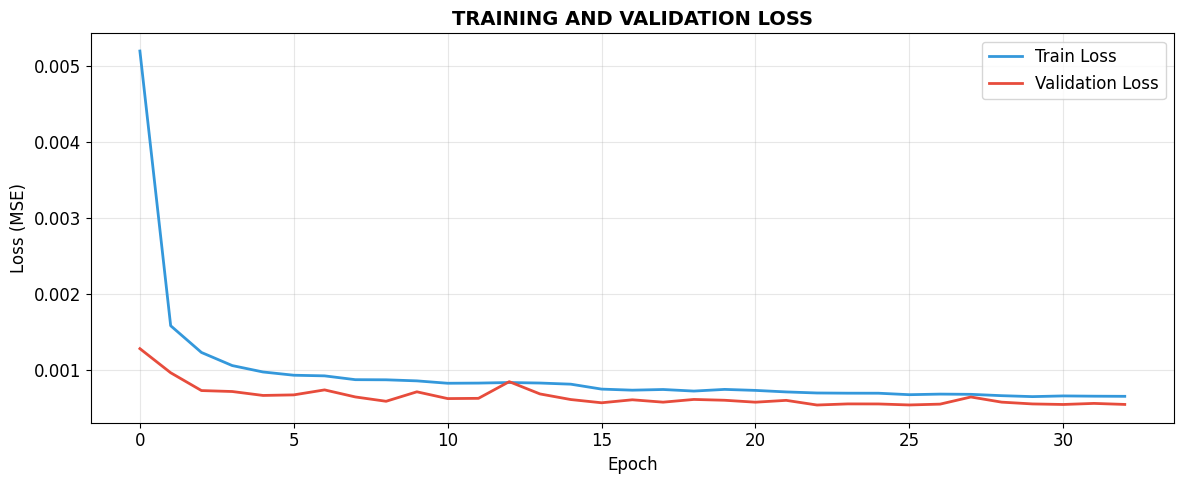

In [21]:
# Visualize training history
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(train_losses, label='Train Loss', color='#3498DB', linewidth=2)
ax.plot(val_losses, label='Validation Loss', color='#E74C3C', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('TRAINING AND VALIDATION LOSS', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 6. MODEL EVALUATION


In [22]:
# =============================================================================
# 6. MODEL EVALUATION - MULTI-OUTPUT
# =============================================================================

def predict_multi_output(model, data_loader, device):
    """Predict with multi-output model"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())
    
    return np.array(predictions), np.array(actuals)

# Predict on test set
y_pred_scaled, y_actual_scaled = predict_multi_output(model, test_loader, device)

# Inverse transform for both outputs
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_actual_scaled)

# Separate PM2.5 and AQI
y_pred_pm25 = y_pred[:, 0]
y_pred_aqi = y_pred[:, 1]
y_actual_pm25 = y_actual[:, 0]
y_actual_aqi = y_actual[:, 1]

print("MULTI-OUTPUT PREDICTIONS:")
print("="*50)
print(f"  • Total predictions: {len(y_pred):,}")
print(f"  • PM2.5 range: [{y_pred_pm25.min():.1f}, {y_pred_pm25.max():.1f}]")
print(f"  • AQI range: [{y_pred_aqi.min():.1f}, {y_pred_aqi.max():.1f}]")


MULTI-OUTPUT PREDICTIONS:
  • Total predictions: 5,254
  • PM2.5 range: [2.1, 540.0]
  • AQI range: [21.5, 524.1]


In [23]:
# =============================================================================
# CALCULATE METRICS FOR BOTH PM2.5 AND AQI
# =============================================================================

def calculate_metrics(y_true, y_pred, name):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {'name': name, 'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Calculate metrics for PM2.5
metrics_pm25 = calculate_metrics(y_actual_pm25, y_pred_pm25, 'PM2.5')

# Calculate metrics for AQI
metrics_aqi = calculate_metrics(y_actual_aqi, y_pred_aqi, 'AQI')

# Display results
print("╔" + "═"*70 + "╗")
print("║" + " MULTI-OUTPUT MODEL EVALUATION ON TEST SET ".center(70) + "║")
print("╠" + "═"*70 + "╣")

print("║" + " PM2.5 PREDICTION ".center(70) + "║")
print("╠" + "─"*70 + "╣")
print(f"║  • MAE  (Mean Absolute Error):     {metrics_pm25['mae']:8.4f} μg/m³".ljust(71) + "║")
print(f"║  • RMSE (Root Mean Square Error):  {metrics_pm25['rmse']:8.4f} μg/m³".ljust(71) + "║")
print(f"║  • R²   (Coefficient of Det.):     {metrics_pm25['r2']:8.4f}".ljust(71) + "║")
print(f"║  • MAPE (Mean Absolute % Error):   {metrics_pm25['mape']:8.2f}%".ljust(71) + "║")

print("╠" + "═"*70 + "╣")
print("║" + " AQI PREDICTION ".center(70) + "║")
print("╠" + "─"*70 + "╣")
print(f"║  • MAE  (Mean Absolute Error):     {metrics_aqi['mae']:8.4f}".ljust(71) + "║")
print(f"║  • RMSE (Root Mean Square Error):  {metrics_aqi['rmse']:8.4f}".ljust(71) + "║")
print(f"║  • R²   (Coefficient of Det.):     {metrics_aqi['r2']:8.4f}".ljust(71) + "║")
print(f"║  • MAPE (Mean Absolute % Error):   {metrics_aqi['mape']:8.2f}%".ljust(71) + "║")

print("╚" + "═"*70 + "╝")

# Save metrics to dict for later use
metrics = {
    'pm25': metrics_pm25,
    'aqi': metrics_aqi
}


╔══════════════════════════════════════════════════════════════════════╗
║              MULTI-OUTPUT MODEL EVALUATION ON TEST SET               ║
╠══════════════════════════════════════════════════════════════════════╣
║                           PM2.5 PREDICTION                           ║
╠──────────────────────────────────────────────────────────────────────╣
║  • MAE  (Mean Absolute Error):       5.3886 μg/m³                    ║
║  • RMSE (Root Mean Square Error):    9.4714 μg/m³                    ║
║  • R²   (Coefficient of Det.):       0.9881                          ║
║  • MAPE (Mean Absolute % Error):      10.60%                         ║
╠══════════════════════════════════════════════════════════════════════╣
║                            AQI PREDICTION                            ║
╠──────────────────────────────────────────────────────────────────────╣
║  • MAE  (Mean Absolute Error):       6.5557                          ║
║  • RMSE (Root Mean Square Error):   10.5399      

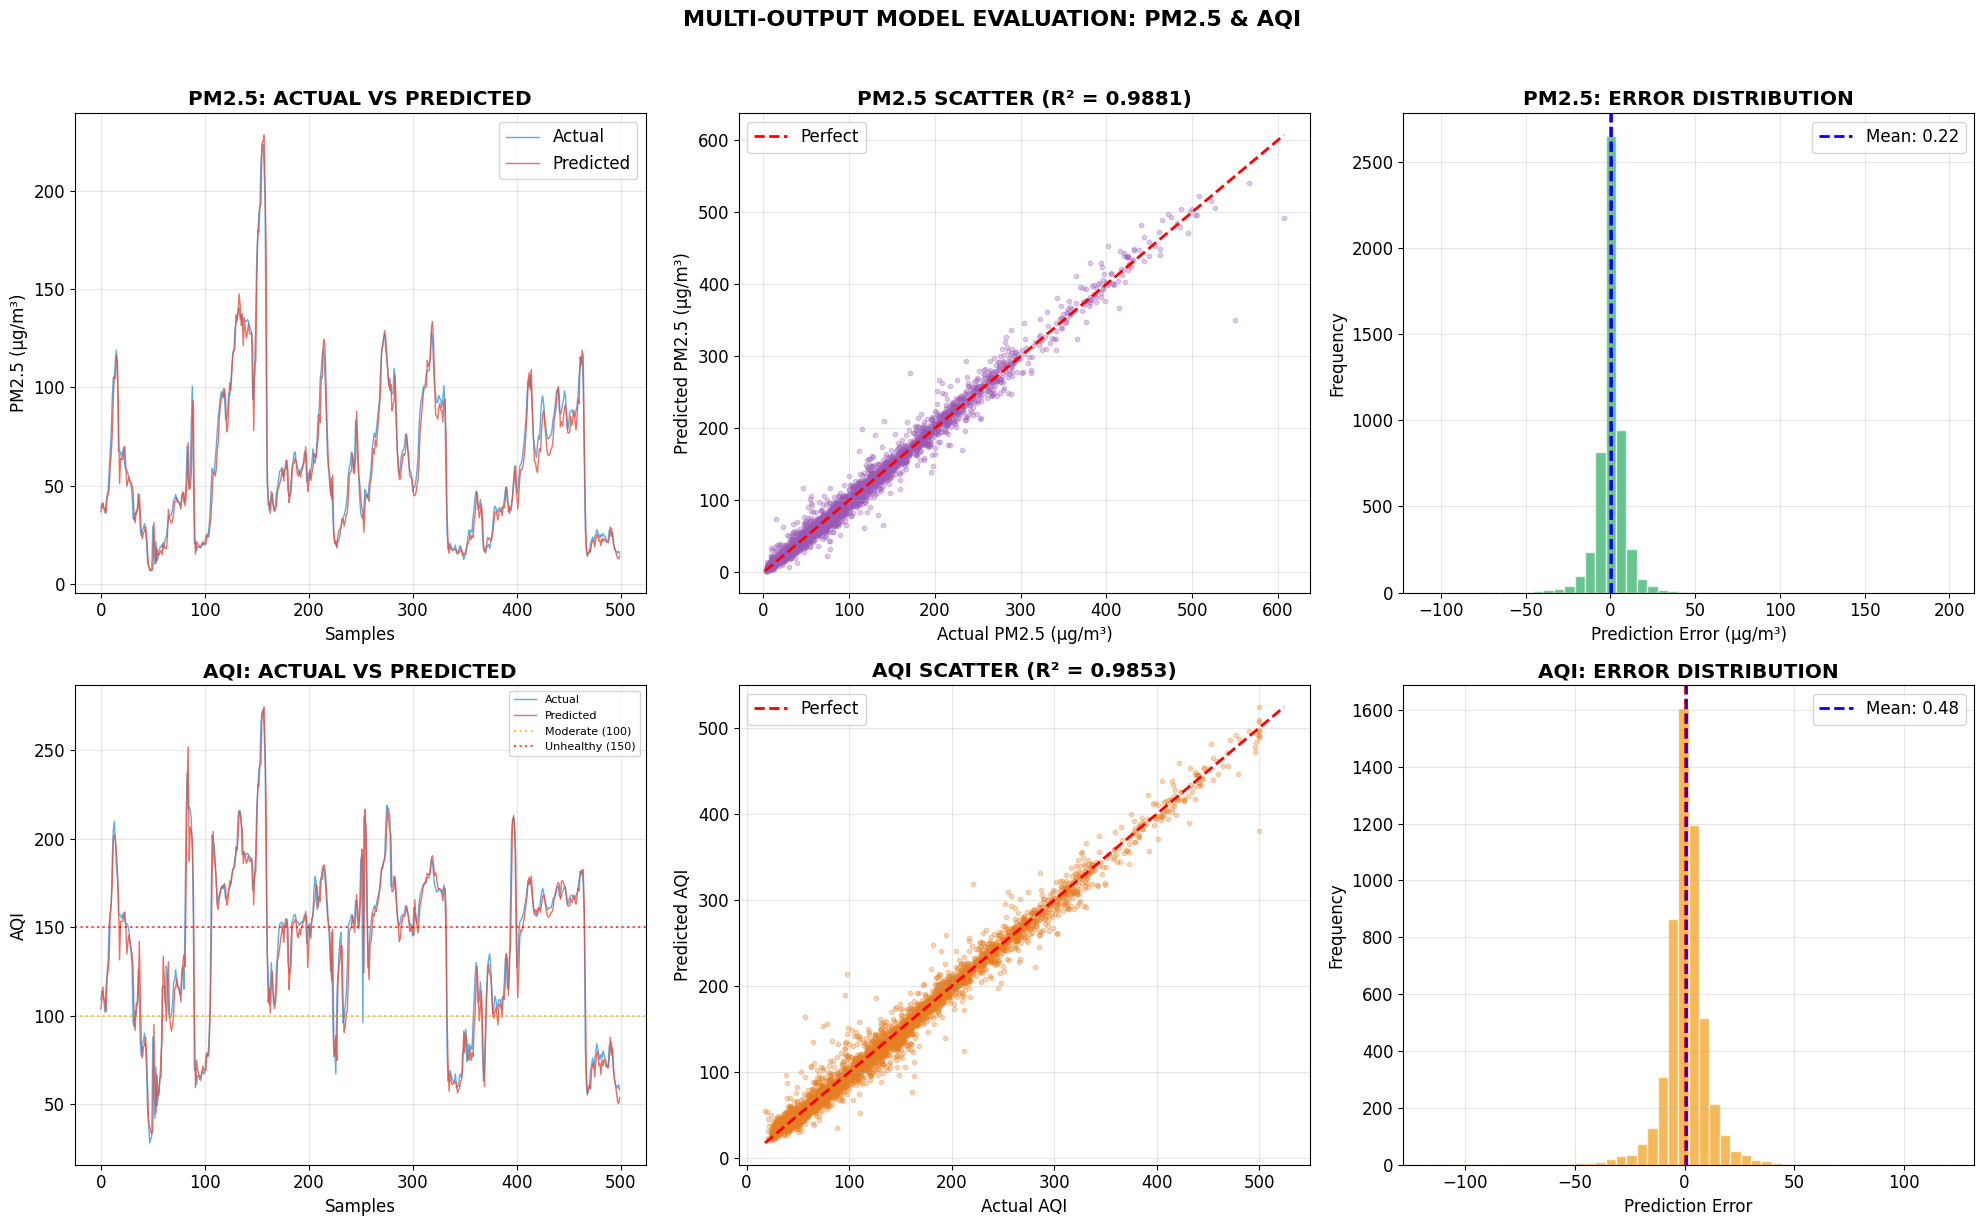

In [24]:
# =============================================================================
# VISUALIZE PREDICTION RESULTS FOR BOTH PM2.5 AND AQI
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# ============ ROW 1: PM2.5 ============
# 1.1 Actual vs Predicted PM2.5
axes[0, 0].plot(y_actual_pm25[:500], label='Actual', alpha=0.8, color='#3498DB', linewidth=1)
axes[0, 0].plot(y_pred_pm25[:500], label='Predicted', alpha=0.8, color='#E74C3C', linewidth=1)
axes[0, 0].set_xlabel('Samples')
axes[0, 0].set_ylabel('PM2.5 (μg/m³)')
axes[0, 0].set_title('PM2.5: ACTUAL VS PREDICTED', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 1.2 Scatter plot PM2.5
axes[0, 1].scatter(y_actual_pm25, y_pred_pm25, alpha=0.3, s=10, color='#9B59B6')
min_val = min(y_actual_pm25.min(), y_pred_pm25.min())
max_val = max(y_actual_pm25.max(), y_pred_pm25.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
axes[0, 1].set_xlabel('Actual PM2.5 (μg/m³)')
axes[0, 1].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[0, 1].set_title(f'PM2.5 SCATTER (R² = {metrics_pm25["r2"]:.4f})', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 1.3 Error distribution PM2.5
errors_pm25 = y_actual_pm25 - y_pred_pm25
axes[0, 2].hist(errors_pm25, bins=50, color='#27AE60', edgecolor='white', alpha=0.7)
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 2].axvline(x=np.mean(errors_pm25), color='blue', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(errors_pm25):.2f}')
axes[0, 2].set_xlabel('Prediction Error (μg/m³)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('PM2.5: ERROR DISTRIBUTION', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# ============ ROW 2: AQI ============
# 2.1 Actual vs Predicted AQI
axes[1, 0].plot(y_actual_aqi[:500], label='Actual', alpha=0.8, color='#3498DB', linewidth=1)
axes[1, 0].plot(y_pred_aqi[:500], label='Predicted', alpha=0.8, color='#E74C3C', linewidth=1)
axes[1, 0].axhline(y=100, color='orange', linestyle=':', alpha=0.7, label='Moderate (100)')
axes[1, 0].axhline(y=150, color='red', linestyle=':', alpha=0.7, label='Unhealthy (150)')
axes[1, 0].set_xlabel('Samples')
axes[1, 0].set_ylabel('AQI')
axes[1, 0].set_title('AQI: ACTUAL VS PREDICTED', fontweight='bold')
axes[1, 0].legend(loc='upper right', fontsize=8)
axes[1, 0].grid(alpha=0.3)

# 2.2 Scatter plot AQI
axes[1, 1].scatter(y_actual_aqi, y_pred_aqi, alpha=0.3, s=10, color='#E67E22')
min_val = min(y_actual_aqi.min(), y_pred_aqi.min())
max_val = max(y_actual_aqi.max(), y_pred_aqi.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
axes[1, 1].set_xlabel('Actual AQI')
axes[1, 1].set_ylabel('Predicted AQI')
axes[1, 1].set_title(f'AQI SCATTER (R² = {metrics_aqi["r2"]:.4f})', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 2.3 Error distribution AQI
errors_aqi = y_actual_aqi - y_pred_aqi
axes[1, 2].hist(errors_aqi, bins=50, color='#F39C12', edgecolor='white', alpha=0.7)
axes[1, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 2].axvline(x=np.mean(errors_aqi), color='blue', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(errors_aqi):.2f}')
axes[1, 2].set_xlabel('Prediction Error')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('AQI: ERROR DISTRIBUTION', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.suptitle('MULTI-OUTPUT MODEL EVALUATION: PM2.5 & AQI', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 7. FUTURE FORECASTING (MULTI-STEP FORECASTING)


In [25]:
# =============================================================================
# 7. FUTURE FORECASTING (MULTI-OUTPUT: PM2.5 & AQI)
# =============================================================================

def forecast_future_multi(model, last_sequence, n_steps, target_scaler, device):
    """
    Forecast n steps ahead for both PM2.5 and AQI
    Returns: predictions (n_steps, 2) - [PM2.5, AQI]
    """
    model.eval()
    predictions = []
    current_seq = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(n_steps):
            # Prepare input
            seq_tensor = torch.FloatTensor(current_seq).unsqueeze(0).to(device)
            
            # Predict multi-output [PM2.5, AQI]
            pred = model(seq_tensor).cpu().numpy()[0]  # Shape: (2,)
            predictions.append(pred)
            
            # Update sequence (rolling window)
            new_row = current_seq[-1].copy()
            new_row[0] = pred[0]   # Update PM2.5 (feature 0)
            new_row[-1] = pred[1]  # Update AQI (last feature)
            current_seq = np.vstack([current_seq[1:], new_row])
    
    # Inverse transform
    predictions = np.array(predictions)  # Shape: (n_steps, 2)
    predictions = target_scaler.inverse_transform(predictions)
    
    return predictions

# Get last sequence from data
last_sequence = feature_scaled[-config.SEQUENCE_LENGTH:]

# Forecast next 24, 48, and 72 hours
forecast_24h = forecast_future_multi(model, last_sequence, 24, target_scaler, device)
forecast_48h = forecast_future_multi(model, last_sequence, 48, target_scaler, device)
forecast_72h = forecast_future_multi(model, last_sequence, 72, target_scaler, device)

# Separate PM2.5 and AQI
forecast_pm25_24h, forecast_aqi_24h = forecast_24h[:, 0], forecast_24h[:, 1]
forecast_pm25_72h, forecast_aqi_72h = forecast_72h[:, 0], forecast_72h[:, 1]

print("FUTURE FORECAST (PM2.5 & AQI):")
print("="*70)
print("\nPM2.5 FORECAST:")
print("-"*40)
print(f"  24h: Min={forecast_pm25_24h.min():.1f} | Max={forecast_pm25_24h.max():.1f} | Mean={forecast_pm25_24h.mean():.1f} μg/m³")
print(f"  72h: Min={forecast_pm25_72h.min():.1f} | Max={forecast_pm25_72h.max():.1f} | Mean={forecast_pm25_72h.mean():.1f} μg/m³")

print("\nAQI FORECAST:")
print("-"*40)
print(f"  24h: Min={forecast_aqi_24h.min():.0f} | Max={forecast_aqi_24h.max():.0f} | Mean={forecast_aqi_24h.mean():.0f}")
print(f"  72h: Min={forecast_aqi_72h.min():.0f} | Max={forecast_aqi_72h.max():.0f} | Mean={forecast_aqi_72h.mean():.0f}")


FUTURE FORECAST (PM2.5 & AQI):

PM2.5 FORECAST:
----------------------------------------
  24h: Min=13.8 | Max=16.8 | Mean=14.5 μg/m³
  72h: Min=13.7 | Max=16.8 | Mean=14.0 μg/m³

AQI FORECAST:
----------------------------------------
  24h: Min=53 | Max=61 | Mean=55
  72h: Min=53 | Max=61 | Mean=53


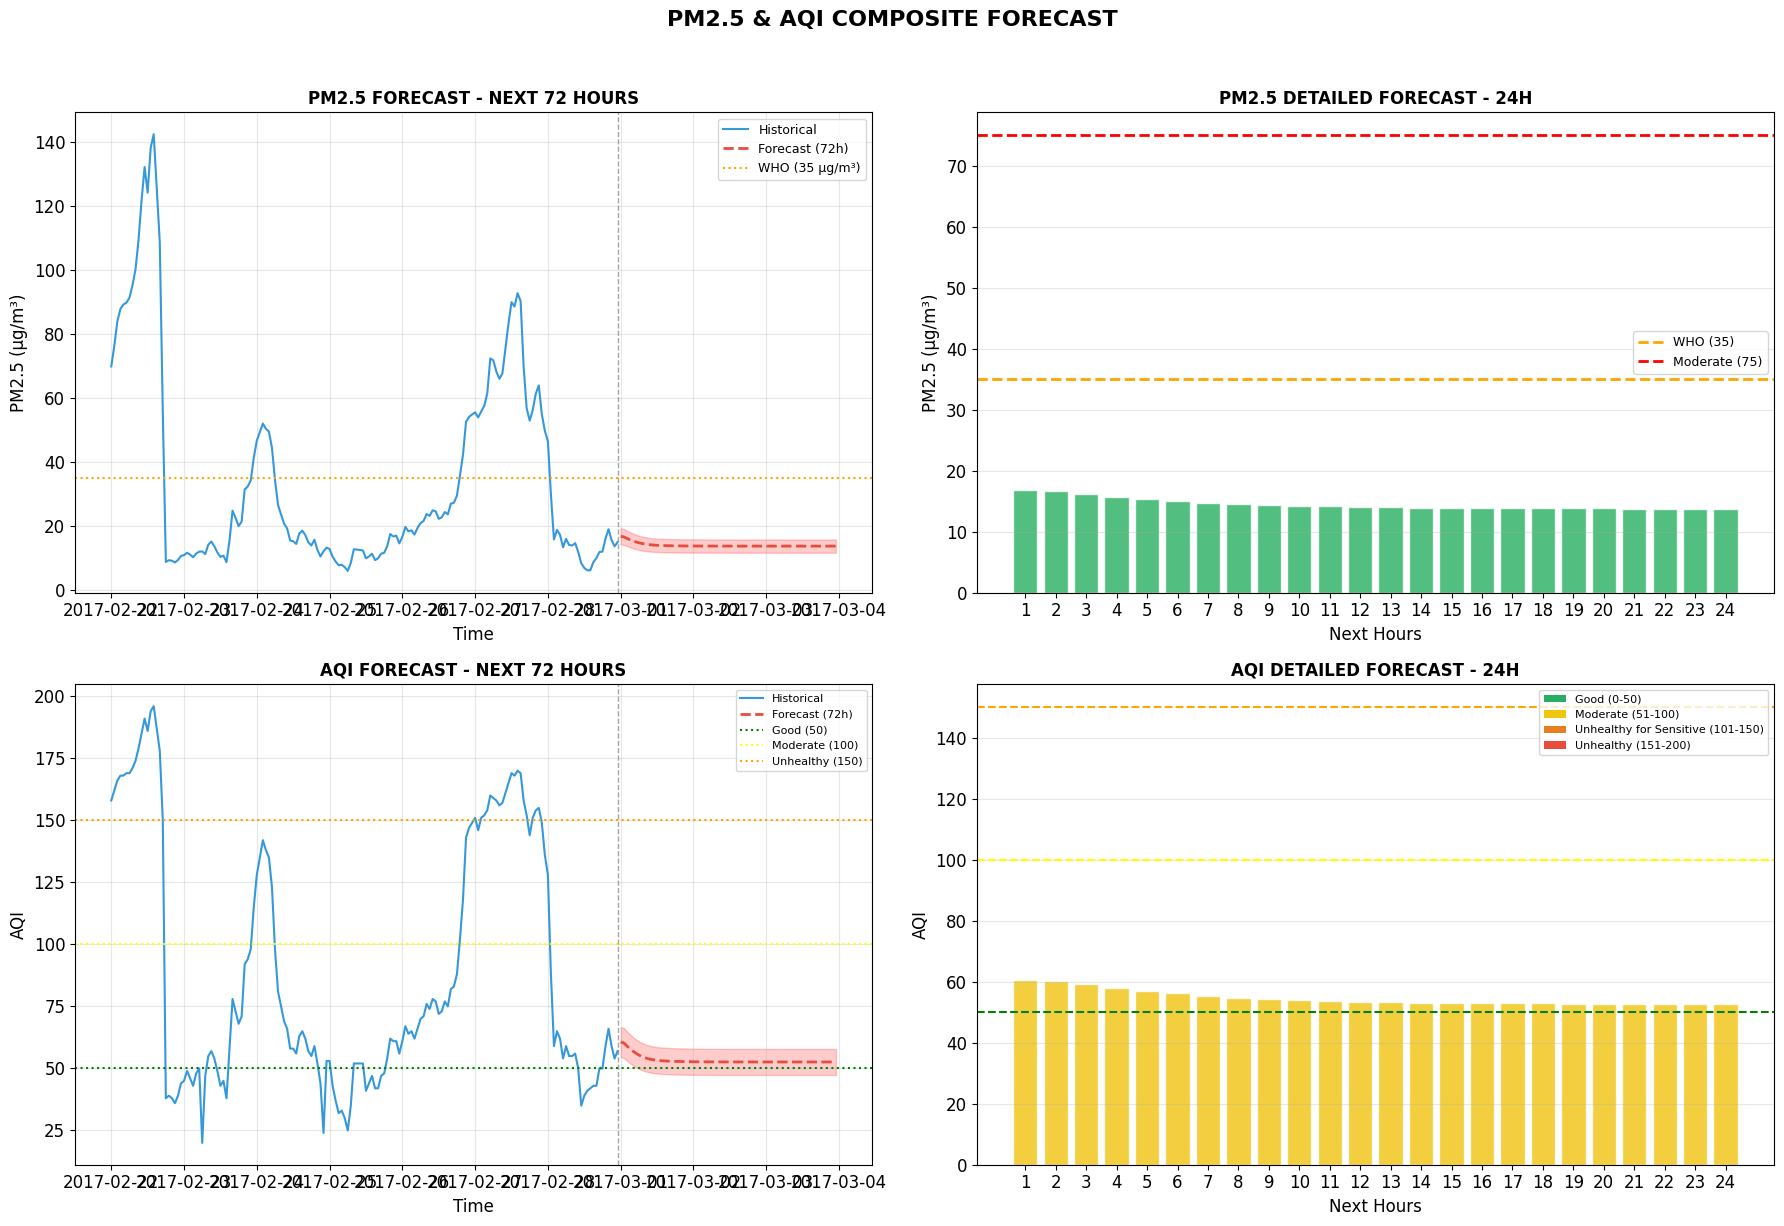

In [26]:
# =============================================================================
# VISUALIZE PM2.5 & AQI FORECAST
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Get last 168 hours (7 days) of actual data
last_pm25 = df_avg['PM2.5'].values[-168:]
last_aqi = df_avg['AQI'].values[-168:]
last_dates = df_avg['datetime'].values[-168:]

# Create dates for forecast
last_date = pd.to_datetime(df_avg['datetime'].values[-1])
forecast_dates_72h = pd.date_range(start=last_date + timedelta(hours=1), periods=72, freq='H')
forecast_dates_24h = pd.date_range(start=last_date + timedelta(hours=1), periods=24, freq='H')

# ============ ROW 1: PM2.5 ============
# 1.1 Historical + Forecast PM2.5
axes[0, 0].plot(last_dates, last_pm25, label='Historical', color='#3498DB', linewidth=1.5)
axes[0, 0].plot(forecast_dates_72h, forecast_pm25_72h, label='Forecast (72h)', 
                color='#E74C3C', linewidth=2, linestyle='--')
axes[0, 0].axhline(y=35, color='orange', linestyle=':', linewidth=1.5, label='WHO (35 μg/m³)')
axes[0, 0].axvline(x=last_date, color='gray', linestyle='--', linewidth=1, alpha=0.7)
axes[0, 0].fill_between(forecast_dates_72h, forecast_pm25_72h * 0.85, forecast_pm25_72h * 1.15, 
                        alpha=0.2, color='red')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('PM2.5 (μg/m³)')
axes[0, 0].set_title('PM2.5 FORECAST - NEXT 72 HOURS', fontweight='bold', fontsize=12)
axes[0, 0].legend(loc='upper right', fontsize=9)
axes[0, 0].grid(alpha=0.3)

# 1.2 Detailed 24h PM2.5 forecast
hours = np.arange(1, 25)
colors_pm25 = ['#27AE60' if v < 35 else '#F39C12' if v < 75 else '#E74C3C' for v in forecast_pm25_24h]
bars = axes[0, 1].bar(hours, forecast_pm25_24h, color=colors_pm25, edgecolor='white', alpha=0.8)
axes[0, 1].axhline(y=35, color='orange', linestyle='--', linewidth=2, label='WHO (35)')
axes[0, 1].axhline(y=75, color='red', linestyle='--', linewidth=2, label='Moderate (75)')
axes[0, 1].set_xlabel('Next Hours')
axes[0, 1].set_ylabel('PM2.5 (μg/m³)')
axes[0, 1].set_title('PM2.5 DETAILED FORECAST - 24H', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(hours)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# ============ ROW 2: AQI ============
# 2.1 Historical + Forecast AQI
axes[1, 0].plot(last_dates, last_aqi, label='Historical', color='#3498DB', linewidth=1.5)
axes[1, 0].plot(forecast_dates_72h, forecast_aqi_72h, label='Forecast (72h)', 
                color='#E74C3C', linewidth=2, linestyle='--')
axes[1, 0].axhline(y=50, color='green', linestyle=':', linewidth=1.5, label='Good (50)')
axes[1, 0].axhline(y=100, color='yellow', linestyle=':', linewidth=1.5, label='Moderate (100)')
axes[1, 0].axhline(y=150, color='orange', linestyle=':', linewidth=1.5, label='Unhealthy (150)')
axes[1, 0].axvline(x=last_date, color='gray', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 0].fill_between(forecast_dates_72h, forecast_aqi_72h * 0.9, forecast_aqi_72h * 1.1, 
                        alpha=0.2, color='red')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('AQI')
axes[1, 0].set_title('AQI FORECAST - NEXT 72 HOURS', fontweight='bold', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=8)
axes[1, 0].grid(alpha=0.3)

# 2.2 Detailed 24h AQI forecast with levels
colors_aqi = []
for v in forecast_aqi_24h:
    if v <= 50: colors_aqi.append('#27AE60')       # Good
    elif v <= 100: colors_aqi.append('#F1C40F')    # Moderate
    elif v <= 150: colors_aqi.append('#E67E22')    # Unhealthy for Sensitive
    elif v <= 200: colors_aqi.append('#E74C3C')    # Unhealthy
    else: colors_aqi.append('#8E44AD')             # Very Unhealthy

bars = axes[1, 1].bar(hours, forecast_aqi_24h, color=colors_aqi, edgecolor='white', alpha=0.8)
axes[1, 1].axhline(y=50, color='green', linestyle='--', linewidth=1.5)
axes[1, 1].axhline(y=100, color='yellow', linestyle='--', linewidth=1.5)
axes[1, 1].axhline(y=150, color='orange', linestyle='--', linewidth=1.5)
axes[1, 1].set_xlabel('Next Hours')
axes[1, 1].set_ylabel('AQI')
axes[1, 1].set_title('AQI DETAILED FORECAST - 24H', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(hours)
axes[1, 1].grid(axis='y', alpha=0.3)

# Legend for AQI levels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27AE60', label='Good (0-50)'),
    Patch(facecolor='#F1C40F', label='Moderate (51-100)'),
    Patch(facecolor='#E67E22', label='Unhealthy for Sensitive (101-150)'),
    Patch(facecolor='#E74C3C', label='Unhealthy (151-200)'),
]
axes[1, 1].legend(handles=legend_elements, loc='upper right', fontsize=8)

plt.suptitle('PM2.5 & AQI COMPOSITE FORECAST', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 8. SAVE MODEL


In [27]:
# =============================================================================
# 8. SAVE MULTI-OUTPUT MODEL
# =============================================================================

import pickle

# Save PyTorch model
model_path = 'pm25_aqi_lstm_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'input_size': input_size,
        'hidden_size': config.HIDDEN_SIZE,
        'num_layers': config.NUM_LAYERS,
        'num_outputs': config.NUM_OUTPUTS,
        'dropout': config.DROPOUT,
        'sequence_length': config.SEQUENCE_LENGTH,
        'targets': config.TARGETS,
        'features': config.FEATURES
    },
    'metrics': {
        'pm25': metrics_pm25,
        'aqi': metrics_aqi
    }
}, model_path)

# Save scalers
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open('target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

print("MULTI-OUTPUT MODEL SAVED!")
print("="*50)
print(f"  • Model: {model_path}")
print(f"  • Feature Scaler: feature_scaler.pkl")
print(f"  • Target Scaler: target_scaler.pkl")
print(f"\nOutputs: {config.TARGETS}")


MULTI-OUTPUT MODEL SAVED!
  • Model: pm25_aqi_lstm_model.pth
  • Feature Scaler: feature_scaler.pkl
  • Target Scaler: target_scaler.pkl

Outputs: ['PM2.5', 'AQI']
